
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain daily SLP predictor and associated wave conditions. Based on Camus et al. (2014), Hegermiller et al. (2017) and Rueda et al. (2017)


inputs required: 
  * ESTELA fields for the site location
  * SLP fields from CFSR reanalysis
  * Wave families from *notebook 09*
  * Historical TCs inside radio 14 from *notebook 05*
  
in this notebook:
  * Construct daily SLP predictor
  * Obtain Daily Weather Types (DWT) and probabilities of occurrence
  * Associate wave conditions to each DWT

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.estela import spatial_gradient, Predictor
from teslakit.util.time_operations import xds_common_dates_daily

from teslakit.plotting.estela import Plot_ESTELA
from teslakit.plotting.wts import Plot_Probs_WT_WT, Plot_Probs_WT_WT_anomaly
from teslakit.plotting.waves import Plot_Waves_DWTs



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# load data and set parameters

ESTELA = db.Load_ESTELA_data()            # ESTELA D data
SLP = db.Load_ESTELA_SLP()                # ESTELA Sea Level Pressure

_, TCs_r1_params = db.Load_TCs_r1_hist()  # TCs historical parameters inside 14º radius 

WAVES_runup_E = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN/HYCREWW/hist_runup_E.nc')
WAVES_runup_S = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN/HYCREWW/hist_runup_S.nc')

# KMA REGRESSION GUIDED parameters
kma_date_ini = '1979-01-22'
kma_date_end = '2017-01-01'
num_clusters = 36
kmarg_alpha = 0.36



## ESTELA Predictor - Sea Level Pressure and Gradient

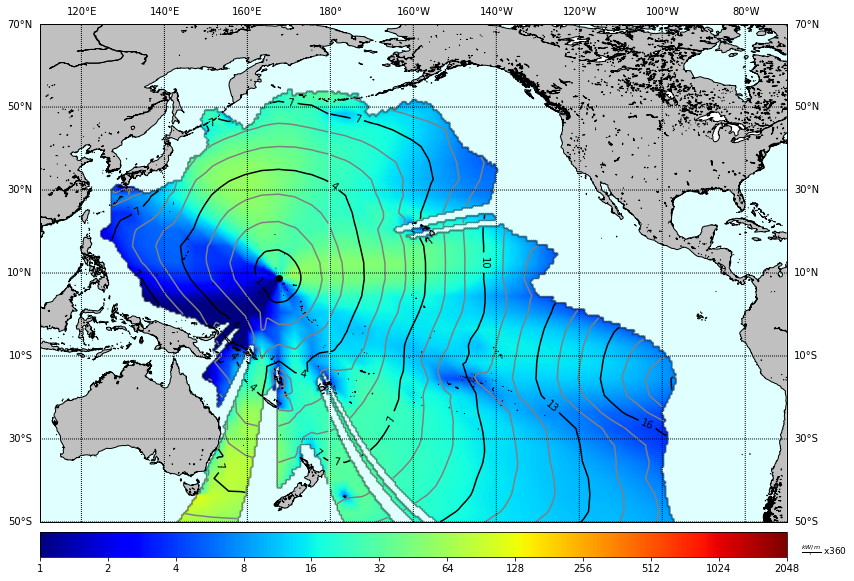

In [4]:
# --------------------------------------
# Plot ESTELA and wave point coordinates

mask_plot = ESTELA.mask_e95

Plot_ESTELA(
    ESTELA.pnt_longitude, ESTELA.pnt_latitude,
    ESTELA.F_y1993to2012 * mask_plot, 
    ESTELA.D_y1993to2012 * mask_plot,
    lon1 = 110, lon2 = 290, lat1 = -50, lat2 = 70,
);


In [5]:
# --------------------------------------
# calculate mean runup, resample to daily

# select time window and calculate daily mean
WAVES_runup_E_daily = WAVES_runup_E.runup.sel(time = slice(kma_date_ini, kma_date_end)).resample(time='1D').mean()
WAVES_runup_S_daily = WAVES_runup_S.runup.sel(time = slice(kma_date_ini, kma_date_end)).resample(time='1D').mean()

# Cuando Hs o Tp, están fuera de los límites de Hycreww, no se obtiene runup (hay NaNS)
WAVES_runup_E_daily = WAVES_runup_E_daily.interpolate_na(dim=('time'), method='linear')
WAVES_runup_S_daily = WAVES_runup_S_daily.interpolate_na(dim=('time'), method='linear')

# mean runup from 3 points
RUNUP = (WAVES_runup_E_daily + WAVES_runup_S_daily)/2.0
RUNUP = RUNUP.to_dataset()    

print(RUNUP)


<xarray.Dataset>
Dimensions:  (time: 13859)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2016-12-31
Data variables:
    runup    (time) float64 2.649 2.589 2.649 2.37 ... 2.266 2.228 2.118 2.178


In [6]:
# --------------------------------------
# Calculate site SLP & SLP_gradient (daily)

# select time window and do data daily mean
SLP_d = SLP.sel(time = slice(kma_date_ini, kma_date_end)).resample(time='1D').mean()

# calculate daily gradients
SLP_d = spatial_gradient(SLP_d, 'SLP')

print(SLP_d)
    

<xarray.Dataset>
Dimensions:       (latitude: 31, longitude: 83, time: 13859)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2016-12-31
  * latitude      (latitude) float32 60.5 58.5 56.5 54.5 ... 6.5 4.5 2.5 0.5
  * longitude     (longitude) float32 115.0 117.0 119.0 ... 275.0 277.0 279.0
Data variables:
    SLP           (time, latitude, longitude) float64 1.019e+05 ... 1.01e+05
    SLP_gradient  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0



## ESTELA Predictor - Principal Component Analysis

In [7]:
# --------------------------------------
# Calculate ESTELA PCA

# select ESTELA at site grid
ESTELA_site = ESTELA.sel(longitude = SLP.longitude, latitude = SLP.latitude)
estela_D = ESTELA_site.D_y1993to2012

# estela masks: data mask (95% energy) and land mask (plots)
estela_mask = ESTELA_site.mask_e95  
estela_land = ESTELA_site.mask_land

# apply ESTELA mask to SLP data
SLP_d['SLP'] = SLP_d.SLP * estela_mask
SLP_d['SLP_gradient'] = SLP_d.SLP_gradient * estela_mask
SLP_d['mask_land'] = estela_land


# Use our custom ESTELA Predictor 
pred = Predictor(db.paths.site.ESTELA.pred_slp)
pred.data = SLP_d

# PCA (dynamic estela predictor)
pred.Calc_PCA_EstelaPred('SLP', estela_D)

# Load predictor PCA, KMA
#pred.Load()

print(pred.PCA)


<xarray.Dataset>
Dimensions:        (n_components: 2118, n_features: 2118, n_lat: 31, n_lon: 83, n_points: 5146, time: 13837)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 2.417 -5.071 ... 1.179e-15
    EOFs           (n_components, n_features) float64 0.03992 0.04064 ... 1.0
    variance       (n_components) float64 258.3 199.9 ... 1.263e-30 1.263e-30
    pred_mean      (n_features) float64 1.012e+05 1.011e+05 ... 0.0 0.0
    pred_std       (n_features) float64 481.7 427.6 664.6 640.3 ... 0.0 0.0 0.0
    pred_lon       (n_lon) float64 115.0 117.0 119.0 121.0 ... 275.0 277.0 279.0
    pred_lat       (n_lat) float64 60.5 58.5 56.5 54.5 52.5 ... 6.5 4.5 2.5 0.5
    pred_time      (time) datetime64[ns] 1979-02-13 1979-02-14 ... 2016-12-31
    pred_data_pos  (n_points) bool False False False False ... False False False
Attributes:
    method:     gradient + estela
    pred_name:  SLP


<xarray.Dataset>
Dimensions:        (n_components: 2118, n_features: 2118, n_lat: 31, n_lon: 83, n_points: 5146, time: 13837)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 2.417 -5.071 ... 1.179e-15
    EOFs           (n_components, n_features) float64 0.03992 0.04064 ... 1.0
    variance       (n_components) float64 258.3 199.9 ... 1.263e-30 1.263e-30
    pred_mean      (n_features) float64 1.012e+05 1.011e+05 ... 0.0 0.0
    pred_std       (n_features) float64 481.7 427.6 664.6 640.3 ... 0.0 0.0 0.0
    pred_lon       (n_lon) float64 115.0 117.0 119.0 121.0 ... 275.0 277.0 279.0
    pred_lat       (n_lat) float64 60.5 58.5 56.5 54.5 52.5 ... 6.5 4.5 2.5 0.5
    pred_time      (time) datetime64[ns] 1979-02-13 1979-02-14 ... 2016-12-31
    pred_data_pos  (n_points) bool False False False False ... False False False
Attributes:
    method:     gradient + estela
    pred_name:  SLP


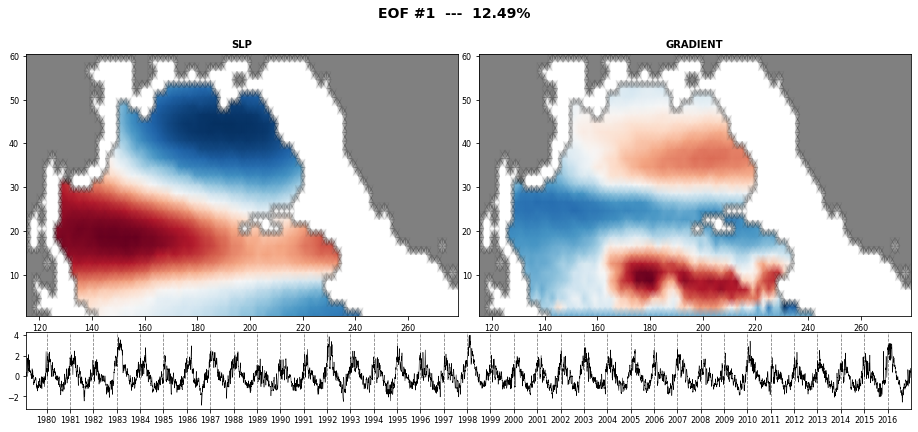

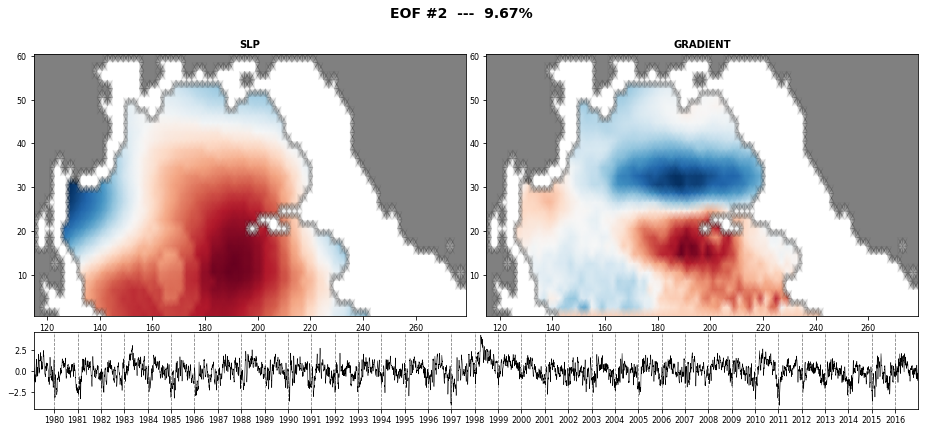

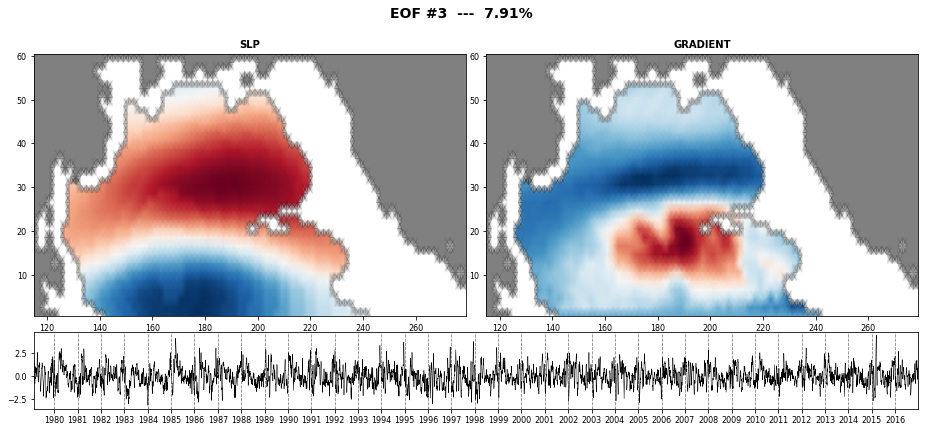

In [8]:
# plot PCA EOFs
n_EOFs = 3

pred.Plot_EOFs_EstelaPred(n_EOFs, show=True);



## ESTELA Predictor - KMeans Classification

In [9]:
# Calculate KMA (regression guided with RUNUP data)
pred.Calc_KMA_regressionguided(
    num_clusters,
    RUNUP, ['runup'],
    kmarg_alpha, min_group_size=50,
)

print(pred.KMA)

sys.exit()

  c: 2 - s: 36
  c: 8 - s: 7
  c: 9 - s: 12
  c: 13 - s: 4
  c: 14 - s: 25
  c: 18 - s: 4
  c: 23 - s: 37
  c: 26 - s: 11
  c: 27 - s: 9
  c: 29 - s: 11
  c: 31 - s: 3
  c: 32 - s: 4
  c: 35 - s: 25
total attemps:  1

  c: 0 - s: 20
  c: 7 - s: 9
  c: 9 - s: 24
  c: 15 - s: 6
  c: 19 - s: 8
  c: 22 - s: 14
  c: 26 - s: 5
  c: 28 - s: 21
  c: 29 - s: 4
  c: 31 - s: 22
  c: 32 - s: 5
  c: 33 - s: 49
  c: 34 - s: 13
total attemps:  2

  c: 0 - s: 17
  c: 1 - s: 40
  c: 3 - s: 11
  c: 8 - s: 23
  c: 9 - s: 25
  c: 18 - s: 30
  c: 20 - s: 9
  c: 21 - s: 9
  c: 23 - s: 30
  c: 24 - s: 22
  c: 26 - s: 4
  c: 27 - s: 4
  c: 30 - s: 5
  c: 33 - s: 12
  c: 34 - s: 30
total attemps:  3

  c: 9 - s: 18
  c: 10 - s: 25
  c: 18 - s: 12
  c: 21 - s: 29
  c: 31 - s: 44
total attemps:  4

  c: 12 - s: 18
  c: 15 - s: 27
  c: 29 - s: 45
total attemps:  5

  c: 0 - s: 3
  c: 2 - s: 6
  c: 6 - s: 12
  c: 9 - s: 37
  c: 13 - s: 10
  c: 15 - s: 16
  c: 16 - s: 32
  c: 19 - s: 29
  c: 20 - s: 40
  c: 21 - s:

  c: 0 - s: 10
  c: 5 - s: 6
  c: 6 - s: 17
  c: 7 - s: 34
  c: 12 - s: 7
  c: 20 - s: 13
  c: 22 - s: 27
  c: 26 - s: 34
  c: 27 - s: 11
  c: 28 - s: 7
  c: 33 - s: 14
  c: 34 - s: 17
  c: 35 - s: 22
total attemps:  46

  c: 0 - s: 14
  c: 5 - s: 5
  c: 7 - s: 41
  c: 8 - s: 29
  c: 9 - s: 11
  c: 14 - s: 7
  c: 15 - s: 35
  c: 17 - s: 6
  c: 19 - s: 24
  c: 22 - s: 16
  c: 26 - s: 21
total attemps:  47

  c: 0 - s: 12
  c: 4 - s: 8
  c: 10 - s: 12
  c: 14 - s: 16
  c: 15 - s: 34
  c: 18 - s: 10
  c: 19 - s: 9
  c: 20 - s: 7
  c: 24 - s: 25
  c: 27 - s: 13
  c: 31 - s: 18
  c: 32 - s: 9
  c: 33 - s: 4
  c: 34 - s: 14
total attemps:  48

  c: 5 - s: 4
  c: 8 - s: 13
  c: 9 - s: 15
  c: 10 - s: 15
  c: 12 - s: 43
  c: 13 - s: 3
  c: 19 - s: 8
  c: 20 - s: 11
  c: 22 - s: 4
  c: 23 - s: 13
  c: 26 - s: 13
  c: 27 - s: 20
  c: 28 - s: 28
  c: 29 - s: 14
  c: 30 - s: 12
  c: 31 - s: 4
  c: 33 - s: 7
total attemps:  49

  c: 0 - s: 9
  c: 12 - s: 26
  c: 16 - s: 5
  c: 17 - s: 11
  c: 20 - 

  c: 8 - s: 12
  c: 9 - s: 8
  c: 12 - s: 8
  c: 13 - s: 4
  c: 14 - s: 8
  c: 26 - s: 9
  c: 28 - s: 28
  c: 33 - s: 10
  c: 34 - s: 35
total attemps:  95

  c: 20 - s: 29
total attemps:  96

  c: 0 - s: 11
  c: 8 - s: 43
  c: 18 - s: 32
  c: 19 - s: 43
  c: 23 - s: 16
total attemps:  97

  c: 3 - s: 18
  c: 26 - s: 10
total attemps:  98

  c: 6 - s: 18
  c: 13 - s: 26
  c: 17 - s: 7
  c: 20 - s: 2
  c: 25 - s: 10
  c: 34 - s: 11
  c: 35 - s: 3
total attemps:  99

  c: 0 - s: 10
  c: 10 - s: 8
  c: 16 - s: 10
  c: 17 - s: 3
  c: 18 - s: 43
  c: 23 - s: 13
  c: 30 - s: 4
  c: 32 - s: 20
  c: 33 - s: 9
  c: 34 - s: 4
  c: 35 - s: 27
total attemps:  100

  c: 0 - s: 36
  c: 15 - s: 46
  c: 16 - s: 48
  c: 25 - s: 44
  c: 28 - s: 41
  c: 30 - s: 18
total attemps:  101

  c: 4 - s: 12
  c: 11 - s: 25
  c: 16 - s: 46
  c: 19 - s: 17
  c: 20 - s: 10
  c: 25 - s: 6
  c: 28 - s: 9
  c: 29 - s: 10
total attemps:  102

  c: 3 - s: 7
  c: 4 - s: 4
  c: 9 - s: 35
  c: 11 - s: 8
  c: 15 - s: 20
  c

  c: 2 - s: 9
  c: 6 - s: 23
  c: 11 - s: 38
  c: 12 - s: 10
  c: 15 - s: 5
  c: 17 - s: 26
  c: 18 - s: 3
  c: 22 - s: 10
  c: 23 - s: 6
  c: 25 - s: 11
  c: 29 - s: 7
  c: 32 - s: 11
  c: 34 - s: 15
  c: 35 - s: 36
total attemps:  150

  c: 15 - s: 23
  c: 19 - s: 22
  c: 29 - s: 27
  c: 30 - s: 23
total attemps:  151

  c: 7 - s: 17
  c: 9 - s: 47
total attemps:  152

  c: 9 - s: 43
  c: 16 - s: 32
  c: 17 - s: 23
  c: 24 - s: 23
  c: 27 - s: 7
total attemps:  153

  c: 6 - s: 13
  c: 8 - s: 11
  c: 10 - s: 4
  c: 14 - s: 25
  c: 16 - s: 26
  c: 17 - s: 3
  c: 20 - s: 46
  c: 21 - s: 8
  c: 23 - s: 3
  c: 24 - s: 7
  c: 26 - s: 4
  c: 27 - s: 10
  c: 30 - s: 12
  c: 32 - s: 4
total attemps:  154

  c: 16 - s: 18
  c: 18 - s: 32
  c: 30 - s: 44
  c: 31 - s: 3
total attemps:  155

  c: 2 - s: 15
  c: 19 - s: 6
  c: 21 - s: 12
  c: 22 - s: 1
  c: 23 - s: 9
  c: 25 - s: 17
  c: 27 - s: 10
  c: 28 - s: 17
  c: 34 - s: 4
  c: 35 - s: 21
total attemps:  156

  c: 2 - s: 26
  c: 5 - s: 15
 

  c: 5 - s: 38
  c: 6 - s: 10
  c: 7 - s: 5
  c: 12 - s: 18
  c: 14 - s: 30
  c: 17 - s: 18
  c: 18 - s: 14
  c: 19 - s: 36
  c: 21 - s: 10
  c: 23 - s: 27
  c: 26 - s: 30
  c: 30 - s: 37
  c: 33 - s: 38
  c: 34 - s: 7
  c: 35 - s: 4
total attemps:  199

  c: 12 - s: 37
total attemps:  200

  c: 7 - s: 19
  c: 8 - s: 7
  c: 24 - s: 8
  c: 28 - s: 20
  c: 30 - s: 20
  c: 34 - s: 18
  c: 35 - s: 4
total attemps:  201

  c: 0 - s: 6
  c: 5 - s: 11
  c: 10 - s: 4
  c: 13 - s: 20
  c: 14 - s: 19
  c: 16 - s: 20
  c: 24 - s: 12
  c: 32 - s: 4
  c: 34 - s: 12
total attemps:  202

  c: 6 - s: 10
  c: 11 - s: 8
  c: 12 - s: 20
  c: 16 - s: 5
  c: 25 - s: 12
  c: 26 - s: 39
  c: 27 - s: 15
  c: 30 - s: 7
  c: 31 - s: 3
  c: 33 - s: 20
  c: 34 - s: 9
  c: 35 - s: 8
total attemps:  203

  c: 3 - s: 23
  c: 14 - s: 16
  c: 18 - s: 5
  c: 19 - s: 11
  c: 24 - s: 16
  c: 26 - s: 7
  c: 27 - s: 9
  c: 28 - s: 45
  c: 29 - s: 37
  c: 31 - s: 15
  c: 33 - s: 3
total attemps:  204

  c: 2 - s: 40
  c: 12

  c: 6 - s: 4
  c: 7 - s: 27
  c: 9 - s: 45
  c: 10 - s: 6
  c: 11 - s: 10
  c: 14 - s: 10
  c: 16 - s: 16
  c: 19 - s: 22
  c: 23 - s: 21
  c: 26 - s: 7
  c: 27 - s: 10
  c: 28 - s: 48
  c: 30 - s: 3
  c: 31 - s: 15
total attemps:  251

  c: 3 - s: 35
  c: 22 - s: 12
  c: 23 - s: 43
  c: 34 - s: 38
total attemps:  252

  c: 6 - s: 36
  c: 7 - s: 25
  c: 12 - s: 4
  c: 18 - s: 34
  c: 19 - s: 20
  c: 22 - s: 11
  c: 29 - s: 44
  c: 32 - s: 36
  c: 33 - s: 14
  c: 34 - s: 9
total attemps:  253

  c: 0 - s: 31
  c: 12 - s: 27
  c: 15 - s: 4
  c: 18 - s: 24
  c: 25 - s: 47
  c: 28 - s: 9
  c: 32 - s: 46
  c: 35 - s: 23
total attemps:  254

  c: 0 - s: 9
  c: 4 - s: 13
  c: 13 - s: 21
  c: 14 - s: 49
  c: 16 - s: 16
  c: 23 - s: 1
  c: 24 - s: 15
  c: 26 - s: 8
  c: 31 - s: 36
  c: 32 - s: 3
  c: 33 - s: 37
  c: 35 - s: 10
total attemps:  255

  c: 6 - s: 4
  c: 10 - s: 3
  c: 11 - s: 15
  c: 13 - s: 9
  c: 21 - s: 13
  c: 22 - s: 14
  c: 23 - s: 3
  c: 25 - s: 7
  c: 26 - s: 38
  c: 27 - 

  c: 14 - s: 42
  c: 17 - s: 18
  c: 27 - s: 4
  c: 32 - s: 49
total attemps:  299

  c: 6 - s: 34
  c: 7 - s: 15
  c: 17 - s: 14
  c: 20 - s: 2
  c: 22 - s: 18
  c: 27 - s: 18
  c: 34 - s: 21
total attemps:  300

  c: 20 - s: 45
  c: 22 - s: 12
  c: 23 - s: 41
  c: 28 - s: 19
  c: 30 - s: 36
  c: 35 - s: 42
total attemps:  301

  c: 7 - s: 38
  c: 14 - s: 5
  c: 16 - s: 10
  c: 18 - s: 16
  c: 33 - s: 40
total attemps:  302

  c: 7 - s: 46
  c: 8 - s: 31
  c: 10 - s: 5
  c: 18 - s: 4
  c: 19 - s: 16
  c: 20 - s: 26
  c: 23 - s: 25
  c: 25 - s: 44
  c: 27 - s: 9
  c: 29 - s: 2
  c: 33 - s: 32
  c: 34 - s: 7
  c: 35 - s: 6
total attemps:  303

  c: 1 - s: 4
  c: 8 - s: 35
  c: 9 - s: 5
  c: 20 - s: 23
  c: 22 - s: 39
  c: 26 - s: 3
  c: 28 - s: 3
total attemps:  304

  c: 0 - s: 12
  c: 15 - s: 10
  c: 16 - s: 6
  c: 17 - s: 46
  c: 18 - s: 29
  c: 21 - s: 6
  c: 22 - s: 35
  c: 26 - s: 9
  c: 27 - s: 12
  c: 30 - s: 15
  c: 34 - s: 16
total attemps:  305

  c: 19 - s: 7
  c: 23 - s: 14

  c: 0 - s: 21
  c: 8 - s: 4
  c: 11 - s: 19
  c: 13 - s: 26
  c: 18 - s: 9
  c: 19 - s: 30
  c: 22 - s: 10
  c: 24 - s: 32
  c: 25 - s: 5
  c: 26 - s: 4
  c: 29 - s: 4
  c: 32 - s: 1
  c: 34 - s: 16
total attemps:  347

  c: 7 - s: 3
  c: 11 - s: 43
  c: 12 - s: 9
  c: 21 - s: 9
  c: 24 - s: 46
  c: 25 - s: 22
  c: 29 - s: 48
total attemps:  348

  c: 0 - s: 3
  c: 3 - s: 24
  c: 4 - s: 11
  c: 6 - s: 10
  c: 7 - s: 20
  c: 13 - s: 6
  c: 15 - s: 15
  c: 18 - s: 8
  c: 20 - s: 40
  c: 22 - s: 33
  c: 29 - s: 18
  c: 30 - s: 1
  c: 31 - s: 34
total attemps:  349

  c: 1 - s: 27
  c: 4 - s: 19
  c: 20 - s: 6
  c: 33 - s: 15
total attemps:  350

  c: 3 - s: 15
  c: 7 - s: 24
  c: 13 - s: 30
  c: 14 - s: 41
  c: 16 - s: 20
  c: 17 - s: 15
  c: 18 - s: 1
  c: 20 - s: 14
  c: 22 - s: 11
  c: 23 - s: 15
  c: 28 - s: 22
  c: 31 - s: 12
  c: 33 - s: 15
total attemps:  351

  c: 11 - s: 11
  c: 12 - s: 14
  c: 15 - s: 16
  c: 16 - s: 7
  c: 18 - s: 36
  c: 20 - s: 14
  c: 23 - s: 37
  c: 24 - s

  c: 3 - s: 7
  c: 6 - s: 27
  c: 10 - s: 2
  c: 12 - s: 23
  c: 14 - s: 20
  c: 19 - s: 15
  c: 22 - s: 19
  c: 25 - s: 5
  c: 26 - s: 9
  c: 30 - s: 5
  c: 34 - s: 9
total attemps:  392

  c: 5 - s: 27
  c: 7 - s: 23
  c: 13 - s: 5
  c: 16 - s: 17
  c: 17 - s: 44
  c: 19 - s: 6
  c: 23 - s: 18
  c: 25 - s: 10
  c: 26 - s: 3
  c: 30 - s: 3
  c: 31 - s: 16
total attemps:  393

  c: 0 - s: 11
  c: 7 - s: 38
  c: 12 - s: 12
  c: 15 - s: 4
  c: 16 - s: 26
  c: 26 - s: 14
  c: 29 - s: 47
total attemps:  394

  c: 0 - s: 7
  c: 2 - s: 11
  c: 5 - s: 7
  c: 7 - s: 15
  c: 9 - s: 11
  c: 11 - s: 18
  c: 16 - s: 13
  c: 18 - s: 22
  c: 19 - s: 9
  c: 20 - s: 39
  c: 27 - s: 9
  c: 28 - s: 12
  c: 30 - s: 20
  c: 32 - s: 8
  c: 33 - s: 22
  c: 35 - s: 32
total attemps:  395

  c: 0 - s: 11
  c: 10 - s: 46
  c: 14 - s: 12
  c: 15 - s: 36
  c: 16 - s: 9
  c: 18 - s: 33
  c: 20 - s: 30
  c: 22 - s: 11
  c: 25 - s: 39
  c: 26 - s: 9
  c: 27 - s: 6
  c: 28 - s: 7
  c: 30 - s: 2
  c: 32 - s: 8
  c: 3

  c: 4 - s: 16
  c: 7 - s: 35
  c: 8 - s: 19
  c: 9 - s: 21
  c: 11 - s: 16
  c: 13 - s: 25
  c: 15 - s: 3
  c: 19 - s: 1
  c: 20 - s: 11
  c: 23 - s: 20
  c: 24 - s: 23
  c: 25 - s: 37
  c: 33 - s: 8
total attemps:  438

  c: 15 - s: 16
  c: 16 - s: 33
  c: 20 - s: 32
  c: 26 - s: 41
  c: 27 - s: 38
  c: 32 - s: 40
  c: 34 - s: 21
total attemps:  439

  c: 4 - s: 8
  c: 6 - s: 11
  c: 7 - s: 27
  c: 12 - s: 6
  c: 15 - s: 11
  c: 16 - s: 21
  c: 17 - s: 33
  c: 19 - s: 20
  c: 24 - s: 9
  c: 27 - s: 25
  c: 28 - s: 35
  c: 30 - s: 32
  c: 32 - s: 13
  c: 35 - s: 20
total attemps:  440

  c: 0 - s: 29
  c: 10 - s: 13
  c: 11 - s: 9
  c: 18 - s: 4
  c: 19 - s: 18
  c: 20 - s: 9
  c: 21 - s: 11
  c: 22 - s: 41
  c: 24 - s: 11
  c: 25 - s: 5
  c: 26 - s: 4
  c: 28 - s: 14
  c: 30 - s: 35
  c: 31 - s: 2
  c: 32 - s: 8
  c: 34 - s: 16
  c: 35 - s: 15
total attemps:  441

  c: 0 - s: 29
  c: 6 - s: 10
  c: 9 - s: 19
  c: 12 - s: 16
  c: 13 - s: 6
  c: 14 - s: 6
  c: 19 - s: 18
  c: 25 - s: 2

  c: 0 - s: 29
  c: 2 - s: 14
  c: 4 - s: 10
  c: 12 - s: 25
  c: 18 - s: 13
  c: 22 - s: 14
  c: 23 - s: 8
  c: 28 - s: 3
  c: 30 - s: 1
  c: 32 - s: 5
  c: 33 - s: 5
total attemps:  482

  c: 0 - s: 33
  c: 4 - s: 12
  c: 9 - s: 39
  c: 27 - s: 33
total attemps:  483

  c: 1 - s: 44
  c: 8 - s: 15
  c: 16 - s: 41
  c: 30 - s: 17
  c: 31 - s: 40
total attemps:  484

  c: 1 - s: 23
  c: 15 - s: 23
  c: 17 - s: 17
  c: 22 - s: 4
  c: 23 - s: 8
  c: 25 - s: 16
  c: 29 - s: 24
  c: 32 - s: 3
  c: 34 - s: 20
total attemps:  485

  c: 9 - s: 49
  c: 10 - s: 26
  c: 13 - s: 35
  c: 18 - s: 44
  c: 19 - s: 20
  c: 25 - s: 19
  c: 35 - s: 39
total attemps:  486

  c: 12 - s: 39
  c: 13 - s: 18
  c: 14 - s: 8
  c: 19 - s: 9
  c: 21 - s: 11
  c: 24 - s: 22
  c: 28 - s: 2
  c: 31 - s: 4
  c: 33 - s: 47
  c: 34 - s: 6
total attemps:  487

  c: 0 - s: 6
  c: 5 - s: 8
  c: 10 - s: 30
  c: 11 - s: 4
  c: 20 - s: 30
  c: 21 - s: 37
  c: 23 - s: 24
  c: 24 - s: 6
  c: 27 - s: 4
  c: 29 - s: 8
  c: 31 -

  c: 9 - s: 10
  c: 11 - s: 22
  c: 16 - s: 24
  c: 22 - s: 42
  c: 31 - s: 46
total attemps:  528

  c: 7 - s: 8
  c: 9 - s: 7
  c: 14 - s: 2
  c: 18 - s: 5
  c: 19 - s: 6
  c: 23 - s: 16
  c: 27 - s: 28
  c: 28 - s: 6
  c: 29 - s: 23
  c: 31 - s: 18
  c: 33 - s: 45
  c: 34 - s: 18
total attemps:  529

  c: 0 - s: 16
  c: 2 - s: 8
  c: 3 - s: 29
  c: 9 - s: 38
  c: 16 - s: 35
  c: 17 - s: 17
  c: 20 - s: 9
  c: 22 - s: 16
  c: 24 - s: 13
  c: 26 - s: 16
  c: 30 - s: 39
  c: 32 - s: 15
total attemps:  530

  c: 3 - s: 10
  c: 5 - s: 41
  c: 7 - s: 23
  c: 9 - s: 9
  c: 10 - s: 49
  c: 14 - s: 12
  c: 22 - s: 12
  c: 27 - s: 39
  c: 35 - s: 21
total attemps:  531

  c: 0 - s: 21
  c: 6 - s: 8
  c: 8 - s: 11
  c: 11 - s: 4
  c: 12 - s: 26
  c: 15 - s: 4
  c: 19 - s: 17
  c: 20 - s: 41
  c: 21 - s: 6
  c: 22 - s: 46
  c: 25 - s: 4
  c: 28 - s: 19
  c: 30 - s: 11
  c: 31 - s: 15
  c: 34 - s: 9
  c: 35 - s: 3
total attemps:  532

  c: 11 - s: 15
  c: 13 - s: 8
  c: 16 - s: 11
  c: 17 - s: 1

  c: 0 - s: 37
  c: 8 - s: 40
  c: 10 - s: 41
  c: 12 - s: 5
  c: 14 - s: 21
  c: 15 - s: 11
  c: 25 - s: 7
  c: 26 - s: 13
  c: 28 - s: 22
  c: 29 - s: 16
  c: 30 - s: 15
  c: 31 - s: 16
total attemps:  572

  c: 5 - s: 11
  c: 7 - s: 13
  c: 12 - s: 21
  c: 17 - s: 7
  c: 23 - s: 18
  c: 24 - s: 3
  c: 25 - s: 11
  c: 28 - s: 6
  c: 29 - s: 27
  c: 30 - s: 4
  c: 31 - s: 6
total attemps:  573

  c: 18 - s: 18
  c: 19 - s: 42
  c: 20 - s: 24
  c: 23 - s: 3
  c: 27 - s: 5
  c: 32 - s: 18
total attemps:  574

  c: 7 - s: 5
  c: 10 - s: 3
  c: 13 - s: 31
  c: 14 - s: 18
  c: 15 - s: 24
  c: 21 - s: 22
  c: 22 - s: 7
  c: 23 - s: 41
  c: 26 - s: 9
  c: 30 - s: 4
  c: 32 - s: 38
  c: 33 - s: 8
  c: 35 - s: 32
total attemps:  575

  c: 0 - s: 23
  c: 4 - s: 40
  c: 6 - s: 45
  c: 12 - s: 2
  c: 19 - s: 24
  c: 22 - s: 5
  c: 23 - s: 2
  c: 24 - s: 38
  c: 31 - s: 18
  c: 32 - s: 15
  c: 33 - s: 39
  c: 34 - s: 21
  c: 35 - s: 27
total attemps:  576

  c: 0 - s: 39
  c: 1 - s: 48
  c: 8 - s:

  c: 4 - s: 6
  c: 5 - s: 13
  c: 9 - s: 17
  c: 10 - s: 15
  c: 18 - s: 33
  c: 19 - s: 47
  c: 23 - s: 15
  c: 25 - s: 12
  c: 26 - s: 21
  c: 28 - s: 37
  c: 30 - s: 11
  c: 31 - s: 12
  c: 33 - s: 36
  c: 35 - s: 3
total attemps:  617

  c: 1 - s: 10
  c: 3 - s: 8
  c: 6 - s: 7
  c: 7 - s: 15
  c: 8 - s: 9
  c: 12 - s: 40
  c: 16 - s: 8
  c: 17 - s: 22
  c: 20 - s: 16
  c: 21 - s: 15
  c: 29 - s: 8
  c: 32 - s: 26
  c: 34 - s: 4
  c: 35 - s: 6
total attemps:  618

  c: 2 - s: 16
  c: 10 - s: 40
  c: 13 - s: 2
  c: 18 - s: 15
  c: 19 - s: 43
  c: 22 - s: 16
  c: 23 - s: 12
  c: 27 - s: 4
  c: 31 - s: 11
  c: 34 - s: 22
  c: 35 - s: 49
total attemps:  619

  c: 2 - s: 15
  c: 5 - s: 8
  c: 8 - s: 18
  c: 11 - s: 5
  c: 15 - s: 9
  c: 17 - s: 4
  c: 18 - s: 9
  c: 20 - s: 13
  c: 21 - s: 19
  c: 23 - s: 5
  c: 26 - s: 16
  c: 28 - s: 5
  c: 31 - s: 5
  c: 34 - s: 8
  c: 35 - s: 11
total attemps:  620

  c: 0 - s: 25
  c: 5 - s: 30
  c: 6 - s: 3
  c: 7 - s: 13
  c: 10 - s: 11
  c: 11 -

  c: 15 - s: 39
  c: 18 - s: 7
  c: 20 - s: 47
  c: 21 - s: 29
  c: 25 - s: 14
  c: 30 - s: 9
  c: 32 - s: 38
  c: 35 - s: 3
total attemps:  663

  c: 5 - s: 3
  c: 7 - s: 7
  c: 10 - s: 12
  c: 15 - s: 23
  c: 19 - s: 12
  c: 20 - s: 30
  c: 22 - s: 9
  c: 23 - s: 3
  c: 25 - s: 43
  c: 27 - s: 16
  c: 28 - s: 5
  c: 30 - s: 27
  c: 33 - s: 14
  c: 34 - s: 16
  c: 35 - s: 16
total attemps:  664

  c: 0 - s: 25
  c: 1 - s: 49
  c: 14 - s: 48
  c: 17 - s: 29
  c: 24 - s: 46
  c: 26 - s: 6
  c: 29 - s: 23
total attemps:  665

  c: 11 - s: 8
  c: 19 - s: 6
  c: 22 - s: 16
  c: 24 - s: 36
  c: 34 - s: 9
total attemps:  666

  c: 6 - s: 15
  c: 7 - s: 4
  c: 8 - s: 46
  c: 10 - s: 29
  c: 15 - s: 16
  c: 16 - s: 31
  c: 17 - s: 26
  c: 18 - s: 9
  c: 19 - s: 42
  c: 20 - s: 3
  c: 21 - s: 25
  c: 24 - s: 14
  c: 26 - s: 10
  c: 27 - s: 40
  c: 29 - s: 19
  c: 33 - s: 29
  c: 34 - s: 9
total attemps:  667

  c: 29 - s: 45
  c: 30 - s: 16
  c: 35 - s: 12
total attemps:  668

  c: 9 - s: 37
  

  c: 8 - s: 5
  c: 10 - s: 10
  c: 14 - s: 14
  c: 16 - s: 27
  c: 18 - s: 14
  c: 19 - s: 48
  c: 22 - s: 8
  c: 24 - s: 8
  c: 26 - s: 10
  c: 29 - s: 1
  c: 31 - s: 21
  c: 32 - s: 19
  c: 34 - s: 30
total attemps:  709

  c: 5 - s: 13
  c: 6 - s: 24
  c: 13 - s: 19
  c: 21 - s: 9
  c: 22 - s: 8
  c: 25 - s: 8
  c: 26 - s: 30
  c: 27 - s: 13
  c: 28 - s: 22
  c: 31 - s: 46
  c: 32 - s: 4
  c: 33 - s: 20
  c: 35 - s: 23
total attemps:  710

  c: 9 - s: 27
  c: 11 - s: 6
  c: 13 - s: 23
  c: 17 - s: 9
  c: 22 - s: 3
  c: 24 - s: 7
  c: 29 - s: 13
  c: 31 - s: 30
  c: 34 - s: 18
total attemps:  711

  c: 4 - s: 35
  c: 11 - s: 35
  c: 17 - s: 10
  c: 20 - s: 23
  c: 27 - s: 17
  c: 28 - s: 9
  c: 32 - s: 23
  c: 33 - s: 11
  c: 34 - s: 4
total attemps:  712

  c: 0 - s: 8
  c: 9 - s: 17
  c: 17 - s: 30
  c: 18 - s: 20
  c: 19 - s: 11
  c: 20 - s: 31
  c: 21 - s: 3
  c: 23 - s: 23
  c: 25 - s: 47
  c: 26 - s: 21
  c: 27 - s: 7
  c: 29 - s: 41
  c: 30 - s: 10
  c: 31 - s: 13
  c: 32 - s:

  c: 4 - s: 15
  c: 5 - s: 24
  c: 9 - s: 49
  c: 14 - s: 7
  c: 17 - s: 26
  c: 27 - s: 20
  c: 31 - s: 5
  c: 32 - s: 4
total attemps:  758

  c: 3 - s: 5
  c: 11 - s: 1
  c: 12 - s: 5
  c: 16 - s: 3
  c: 18 - s: 7
  c: 20 - s: 14
  c: 26 - s: 4
  c: 30 - s: 14
  c: 31 - s: 4
  c: 32 - s: 41
  c: 33 - s: 18
  c: 35 - s: 9
total attemps:  759

  c: 15 - s: 10
  c: 22 - s: 30
  c: 30 - s: 41
  c: 31 - s: 28
  c: 35 - s: 43
total attemps:  760

  c: 1 - s: 30
  c: 5 - s: 6
  c: 6 - s: 25
  c: 7 - s: 21
  c: 12 - s: 3
  c: 14 - s: 37
  c: 19 - s: 9
  c: 23 - s: 29
  c: 24 - s: 8
  c: 28 - s: 5
  c: 29 - s: 16
  c: 31 - s: 32
  c: 32 - s: 17
  c: 34 - s: 6
  c: 35 - s: 6
total attemps:  761

  c: 0 - s: 21
  c: 11 - s: 19
  c: 14 - s: 37
  c: 18 - s: 6
  c: 32 - s: 38
total attemps:  762

  c: 6 - s: 3
  c: 7 - s: 40
  c: 17 - s: 48
  c: 21 - s: 4
  c: 22 - s: 36
  c: 23 - s: 5
  c: 24 - s: 26
  c: 28 - s: 11
  c: 31 - s: 5
  c: 32 - s: 12
  c: 33 - s: 14
total attemps:  763

  c: 8 - s: 

  c: 0 - s: 11
  c: 4 - s: 6
  c: 5 - s: 7
  c: 8 - s: 11
  c: 11 - s: 11
  c: 16 - s: 6
  c: 17 - s: 39
  c: 18 - s: 20
  c: 20 - s: 30
  c: 22 - s: 18
  c: 24 - s: 7
  c: 25 - s: 42
  c: 26 - s: 15
  c: 27 - s: 29
  c: 28 - s: 4
  c: 31 - s: 34
  c: 33 - s: 15
  c: 34 - s: 37
total attemps:  808

  c: 4 - s: 8
  c: 7 - s: 10
  c: 10 - s: 6
  c: 11 - s: 25
  c: 17 - s: 6
  c: 18 - s: 4
  c: 20 - s: 3
  c: 22 - s: 18
  c: 23 - s: 45
  c: 24 - s: 13
  c: 25 - s: 6
  c: 26 - s: 8
  c: 28 - s: 11
  c: 35 - s: 11
total attemps:  809

  c: 4 - s: 47
  c: 15 - s: 20
  c: 16 - s: 19
  c: 26 - s: 40
  c: 29 - s: 38
  c: 30 - s: 8
total attemps:  810

  c: 0 - s: 8
  c: 6 - s: 26
  c: 9 - s: 3
  c: 24 - s: 6
  c: 30 - s: 27
  c: 33 - s: 3
  c: 34 - s: 15
total attemps:  811

  c: 2 - s: 30
  c: 4 - s: 22
  c: 6 - s: 6
  c: 7 - s: 8
  c: 9 - s: 4
  c: 15 - s: 27
  c: 18 - s: 1
  c: 19 - s: 8
  c: 20 - s: 25
  c: 22 - s: 3
  c: 25 - s: 26
  c: 27 - s: 33
  c: 28 - s: 24
  c: 32 - s: 9
  c: 34 - s

  c: 1 - s: 9
  c: 9 - s: 12
  c: 13 - s: 4
  c: 14 - s: 18
  c: 18 - s: 14
  c: 22 - s: 11
  c: 28 - s: 15
  c: 29 - s: 6
  c: 30 - s: 8
  c: 33 - s: 9
total attemps:  856

  c: 2 - s: 21
  c: 5 - s: 30
  c: 10 - s: 33
  c: 12 - s: 49
  c: 14 - s: 7
  c: 16 - s: 9
  c: 17 - s: 8
  c: 18 - s: 27
  c: 21 - s: 17
  c: 23 - s: 2
  c: 24 - s: 6
  c: 25 - s: 10
  c: 27 - s: 22
  c: 30 - s: 6
  c: 32 - s: 13
  c: 33 - s: 19
total attemps:  857

  c: 15 - s: 47
  c: 18 - s: 29
  c: 20 - s: 24
  c: 21 - s: 33
  c: 25 - s: 40
  c: 26 - s: 9
  c: 30 - s: 4
  c: 31 - s: 46
total attemps:  858

  c: 0 - s: 28
  c: 7 - s: 14
  c: 10 - s: 24
  c: 15 - s: 17
  c: 24 - s: 15
  c: 25 - s: 41
  c: 26 - s: 7
  c: 28 - s: 16
  c: 30 - s: 15
  c: 31 - s: 20
  c: 32 - s: 18
  c: 34 - s: 12
  c: 35 - s: 26
total attemps:  859

  c: 9 - s: 3
  c: 18 - s: 8
  c: 19 - s: 7
  c: 22 - s: 32
  c: 26 - s: 15
  c: 28 - s: 20
  c: 30 - s: 23
  c: 31 - s: 5
  c: 32 - s: 6
total attemps:  860

  c: 11 - s: 19
  c: 16 -

  c: 8 - s: 29
  c: 9 - s: 26
  c: 12 - s: 8
  c: 13 - s: 21
  c: 17 - s: 34
  c: 19 - s: 20
  c: 20 - s: 1
  c: 22 - s: 7
  c: 27 - s: 17
  c: 29 - s: 29
  c: 31 - s: 8
  c: 33 - s: 14
  c: 34 - s: 32
  c: 35 - s: 4
total attemps:  908

  c: 14 - s: 26
  c: 17 - s: 20
  c: 25 - s: 9
  c: 31 - s: 28
  c: 34 - s: 20
total attemps:  909

  c: 8 - s: 1
  c: 9 - s: 4
  c: 12 - s: 37
  c: 25 - s: 4
  c: 32 - s: 29
  c: 33 - s: 23
total attemps:  910

  c: 2 - s: 46
  c: 3 - s: 49
  c: 6 - s: 3
  c: 9 - s: 30
  c: 11 - s: 14
  c: 17 - s: 16
  c: 18 - s: 18
  c: 20 - s: 11
  c: 25 - s: 17
  c: 29 - s: 27
  c: 34 - s: 4
  c: 35 - s: 19
total attemps:  911

  c: 0 - s: 5
  c: 9 - s: 21
  c: 12 - s: 8
  c: 13 - s: 25
  c: 17 - s: 1
  c: 19 - s: 6
  c: 27 - s: 12
  c: 28 - s: 3
  c: 33 - s: 19
  c: 34 - s: 40
  c: 35 - s: 17
total attemps:  912

  c: 11 - s: 6
  c: 12 - s: 34
  c: 13 - s: 5
  c: 14 - s: 26
  c: 17 - s: 24
  c: 30 - s: 36
  c: 32 - s: 4
  c: 35 - s: 29
total attemps:  913

  c: 2 

  c: 0 - s: 14
  c: 5 - s: 47
  c: 9 - s: 13
  c: 13 - s: 19
  c: 16 - s: 8
  c: 19 - s: 10
  c: 21 - s: 39
  c: 24 - s: 22
  c: 25 - s: 7
  c: 26 - s: 10
  c: 27 - s: 21
  c: 30 - s: 10
  c: 31 - s: 8
  c: 32 - s: 13
  c: 33 - s: 7
  c: 35 - s: 41
total attemps:  956

  c: 0 - s: 6
  c: 3 - s: 24
  c: 9 - s: 37
  c: 15 - s: 4
  c: 18 - s: 9
  c: 21 - s: 8
total attemps:  957

  c: 7 - s: 3
  c: 16 - s: 20
  c: 26 - s: 34
  c: 31 - s: 15
total attemps:  958

  c: 1 - s: 26
  c: 2 - s: 25
  c: 5 - s: 12
  c: 10 - s: 9
  c: 11 - s: 37
  c: 12 - s: 7
  c: 16 - s: 5
  c: 17 - s: 42
  c: 19 - s: 11
  c: 20 - s: 2
  c: 21 - s: 20
  c: 24 - s: 14
  c: 25 - s: 44
  c: 26 - s: 9
  c: 27 - s: 36
  c: 28 - s: 20
  c: 32 - s: 5
  c: 33 - s: 30
  c: 34 - s: 2
total attemps:  959

  c: 3 - s: 29
  c: 8 - s: 3
  c: 12 - s: 10
  c: 13 - s: 11
  c: 14 - s: 27
  c: 15 - s: 12
  c: 20 - s: 8
  c: 22 - s: 34
  c: 29 - s: 49
  c: 30 - s: 17
  c: 33 - s: 34
  c: 35 - s: 3
total attemps:  960

  c: 17 - s: 1

  c: 6 - s: 13
  c: 8 - s: 21
  c: 12 - s: 15
  c: 13 - s: 9
  c: 24 - s: 27
  c: 25 - s: 34
  c: 26 - s: 9
  c: 32 - s: 22
  c: 34 - s: 29
total attemps:  1005

  c: 6 - s: 19
  c: 9 - s: 4
  c: 10 - s: 17
  c: 12 - s: 25
  c: 13 - s: 30
  c: 14 - s: 2
  c: 15 - s: 22
  c: 17 - s: 8
  c: 23 - s: 5
  c: 25 - s: 5
  c: 29 - s: 22
  c: 31 - s: 12
  c: 33 - s: 15
  c: 35 - s: 3
total attemps:  1006

  c: 3 - s: 13
  c: 9 - s: 47
  c: 11 - s: 12
  c: 24 - s: 37
  c: 25 - s: 4
  c: 27 - s: 13
  c: 30 - s: 22
  c: 35 - s: 12
total attemps:  1007

  c: 0 - s: 2
  c: 1 - s: 13
  c: 3 - s: 21
  c: 11 - s: 21
  c: 18 - s: 15
  c: 19 - s: 4
  c: 21 - s: 33
  c: 22 - s: 9
  c: 25 - s: 26
  c: 27 - s: 27
  c: 32 - s: 31
  c: 33 - s: 6
  c: 34 - s: 12
  c: 35 - s: 3
total attemps:  1008

  c: 7 - s: 24
  c: 8 - s: 8
  c: 24 - s: 28
  c: 29 - s: 39
  c: 32 - s: 45
total attemps:  1009

  c: 2 - s: 1
  c: 11 - s: 5
  c: 16 - s: 6
  c: 17 - s: 20
  c: 19 - s: 6
  c: 21 - s: 5
  c: 23 - s: 3
  c: 27 - s

  c: 0 - s: 43
  c: 5 - s: 43
  c: 21 - s: 8
  c: 24 - s: 16
  c: 29 - s: 18
  c: 30 - s: 28
  c: 32 - s: 42
total attemps:  1056

  c: 4 - s: 17
  c: 9 - s: 30
  c: 11 - s: 17
  c: 13 - s: 5
  c: 14 - s: 5
  c: 15 - s: 20
  c: 16 - s: 9
  c: 19 - s: 5
  c: 21 - s: 24
  c: 22 - s: 49
  c: 28 - s: 14
  c: 29 - s: 13
  c: 30 - s: 16
  c: 31 - s: 14
  c: 32 - s: 3
  c: 34 - s: 15
  c: 35 - s: 6
total attemps:  1057

  c: 1 - s: 7
  c: 9 - s: 8
  c: 17 - s: 10
  c: 19 - s: 11
  c: 23 - s: 14
  c: 28 - s: 18
  c: 29 - s: 19
  c: 33 - s: 39
  c: 34 - s: 40
total attemps:  1058

  c: 3 - s: 28
  c: 13 - s: 3
  c: 14 - s: 20
  c: 33 - s: 17
  c: 34 - s: 29
total attemps:  1059

  c: 8 - s: 13
  c: 12 - s: 13
  c: 13 - s: 11
  c: 14 - s: 8
  c: 17 - s: 17
  c: 18 - s: 11
  c: 23 - s: 25
  c: 24 - s: 34
  c: 26 - s: 43
  c: 28 - s: 10
  c: 29 - s: 13
  c: 31 - s: 23
  c: 33 - s: 12
  c: 34 - s: 14
total attemps:  1060

  c: 12 - s: 4
  c: 13 - s: 3
  c: 14 - s: 20
  c: 17 - s: 9
  c: 20 - s: 4
 

  c: 6 - s: 43
  c: 22 - s: 13
  c: 24 - s: 24
  c: 26 - s: 4
  c: 30 - s: 18
  c: 31 - s: 12
  c: 32 - s: 26
  c: 35 - s: 37
total attemps:  1102

  c: 1 - s: 32
  c: 2 - s: 15
  c: 9 - s: 5
  c: 11 - s: 5
  c: 14 - s: 6
  c: 18 - s: 38
  c: 20 - s: 21
  c: 22 - s: 4
  c: 28 - s: 3
  c: 29 - s: 42
  c: 31 - s: 25
  c: 32 - s: 30
  c: 33 - s: 18
  c: 34 - s: 18
total attemps:  1103

  c: 2 - s: 1
  c: 6 - s: 20
  c: 8 - s: 15
  c: 10 - s: 8
  c: 15 - s: 8
  c: 16 - s: 29
  c: 18 - s: 10
  c: 20 - s: 14
  c: 22 - s: 7
  c: 27 - s: 26
  c: 30 - s: 25
  c: 33 - s: 7
  c: 34 - s: 3
  c: 35 - s: 11
total attemps:  1104

  c: 21 - s: 29
  c: 28 - s: 21
  c: 30 - s: 19
total attemps:  1105

  c: 3 - s: 16
  c: 10 - s: 6
  c: 15 - s: 24
  c: 16 - s: 21
  c: 20 - s: 12
  c: 24 - s: 34
  c: 30 - s: 25
  c: 32 - s: 8
total attemps:  1106

  c: 10 - s: 2
  c: 11 - s: 7
  c: 12 - s: 4
  c: 13 - s: 13
  c: 14 - s: 19
  c: 18 - s: 12
  c: 19 - s: 38
  c: 20 - s: 11
  c: 21 - s: 29
  c: 22 - s: 4
  c:

  c: 13 - s: 4
  c: 15 - s: 45
  c: 17 - s: 44
  c: 24 - s: 21
  c: 33 - s: 32
total attemps:  1145

  c: 7 - s: 8
  c: 21 - s: 19
  c: 22 - s: 46
  c: 25 - s: 20
  c: 28 - s: 49
total attemps:  1146

  c: 6 - s: 16
  c: 7 - s: 9
  c: 9 - s: 6
  c: 11 - s: 16
  c: 12 - s: 25
  c: 16 - s: 8
  c: 19 - s: 33
  c: 21 - s: 25
  c: 22 - s: 10
  c: 25 - s: 23
  c: 26 - s: 11
  c: 28 - s: 39
  c: 30 - s: 4
  c: 32 - s: 8
  c: 33 - s: 14
  c: 34 - s: 39
  c: 35 - s: 7
total attemps:  1147

  c: 2 - s: 20
  c: 3 - s: 15
  c: 5 - s: 34
  c: 9 - s: 20
  c: 10 - s: 16
  c: 11 - s: 25
  c: 14 - s: 12
  c: 17 - s: 9
  c: 23 - s: 5
  c: 25 - s: 11
  c: 29 - s: 18
  c: 30 - s: 5
  c: 33 - s: 8
  c: 35 - s: 5
total attemps:  1148

  c: 0 - s: 19
  c: 2 - s: 13
  c: 4 - s: 33
  c: 12 - s: 19
  c: 15 - s: 11
  c: 20 - s: 9
  c: 25 - s: 16
  c: 26 - s: 11
  c: 28 - s: 1
  c: 30 - s: 10
  c: 33 - s: 31
total attemps:  1149

  c: 3 - s: 2
  c: 4 - s: 19
  c: 7 - s: 18
  c: 10 - s: 35
  c: 14 - s: 18
  c: 16 

  c: 1 - s: 22
  c: 5 - s: 8
  c: 6 - s: 11
  c: 9 - s: 6
  c: 13 - s: 4
  c: 14 - s: 15
  c: 19 - s: 5
  c: 23 - s: 9
  c: 24 - s: 5
  c: 26 - s: 27
  c: 27 - s: 39
  c: 28 - s: 9
  c: 30 - s: 10
  c: 31 - s: 12
  c: 35 - s: 34
total attemps:  1194

  c: 4 - s: 21
  c: 10 - s: 14
  c: 14 - s: 7
  c: 15 - s: 49
  c: 16 - s: 3
  c: 17 - s: 25
  c: 18 - s: 16
  c: 21 - s: 18
  c: 24 - s: 22
  c: 26 - s: 21
  c: 28 - s: 31
  c: 30 - s: 36
  c: 31 - s: 4
  c: 32 - s: 8
  c: 33 - s: 7
  c: 35 - s: 7
total attemps:  1195

  c: 4 - s: 2
  c: 5 - s: 3
  c: 11 - s: 4
  c: 17 - s: 15
  c: 21 - s: 6
  c: 23 - s: 28
  c: 26 - s: 24
  c: 28 - s: 3
  c: 29 - s: 26
  c: 31 - s: 40
  c: 32 - s: 25
  c: 33 - s: 38
  c: 34 - s: 4
total attemps:  1196

  c: 10 - s: 30
  c: 17 - s: 15
  c: 21 - s: 14
  c: 24 - s: 3
  c: 30 - s: 22
  c: 32 - s: 26
  c: 34 - s: 48
  c: 35 - s: 21
total attemps:  1197

  c: 15 - s: 8
  c: 16 - s: 14
  c: 20 - s: 8
  c: 25 - s: 3
  c: 28 - s: 24
  c: 32 - s: 4
  c: 33 - s: 4


  c: 5 - s: 39
  c: 13 - s: 9
  c: 19 - s: 13
  c: 22 - s: 11
  c: 24 - s: 23
  c: 26 - s: 16
  c: 27 - s: 17
  c: 28 - s: 2
  c: 29 - s: 29
  c: 31 - s: 14
  c: 34 - s: 42
  c: 35 - s: 2
total attemps:  1241

  c: 12 - s: 6
  c: 14 - s: 28
  c: 15 - s: 46
  c: 18 - s: 3
  c: 24 - s: 23
  c: 27 - s: 32
  c: 33 - s: 16
total attemps:  1242

  c: 0 - s: 16
  c: 5 - s: 7
  c: 8 - s: 11
  c: 18 - s: 16
  c: 20 - s: 39
  c: 27 - s: 44
  c: 28 - s: 27
  c: 29 - s: 15
  c: 31 - s: 6
  c: 32 - s: 11
  c: 34 - s: 2
  c: 35 - s: 14
total attemps:  1243

  c: 0 - s: 12
  c: 4 - s: 9
  c: 10 - s: 7
  c: 11 - s: 7
  c: 18 - s: 46
  c: 23 - s: 19
  c: 27 - s: 42
  c: 29 - s: 19
  c: 33 - s: 26
  c: 34 - s: 13
  c: 35 - s: 19
total attemps:  1244

  c: 6 - s: 30
  c: 10 - s: 8
  c: 11 - s: 7
  c: 13 - s: 18
  c: 18 - s: 18
  c: 19 - s: 10
  c: 23 - s: 46
  c: 29 - s: 11
  c: 32 - s: 45
  c: 33 - s: 11
  c: 35 - s: 5
total attemps:  1245

  c: 9 - s: 3
  c: 10 - s: 18
  c: 11 - s: 22
  c: 13 - s: 9
  

  c: 0 - s: 7
  c: 6 - s: 34
  c: 7 - s: 2
  c: 8 - s: 26
  c: 11 - s: 33
  c: 16 - s: 40
  c: 18 - s: 34
  c: 19 - s: 12
  c: 22 - s: 19
  c: 27 - s: 11
  c: 29 - s: 18
  c: 30 - s: 31
  c: 34 - s: 16
total attemps:  1288

  c: 1 - s: 15
  c: 6 - s: 14
  c: 11 - s: 16
  c: 18 - s: 6
  c: 23 - s: 9
  c: 25 - s: 22
  c: 27 - s: 16
  c: 29 - s: 6
  c: 31 - s: 26
total attemps:  1289

  c: 3 - s: 46
  c: 7 - s: 13
  c: 12 - s: 31
  c: 13 - s: 10
  c: 14 - s: 6
  c: 15 - s: 28
  c: 17 - s: 19
  c: 19 - s: 2
  c: 21 - s: 7
  c: 23 - s: 9
  c: 26 - s: 23
  c: 31 - s: 17
  c: 32 - s: 29
  c: 33 - s: 17
total attemps:  1290

  c: 0 - s: 42
  c: 3 - s: 14
  c: 6 - s: 44
  c: 8 - s: 18
  c: 14 - s: 30
  c: 17 - s: 34
  c: 24 - s: 8
  c: 25 - s: 3
  c: 32 - s: 5
  c: 35 - s: 29
total attemps:  1291

  c: 3 - s: 41
  c: 5 - s: 3
  c: 6 - s: 23
  c: 10 - s: 31
  c: 15 - s: 27
  c: 16 - s: 18
  c: 17 - s: 8
  c: 18 - s: 4
  c: 19 - s: 6
  c: 20 - s: 13
  c: 22 - s: 4
  c: 25 - s: 6
  c: 28 - s: 15
 

  c: 6 - s: 16
  c: 8 - s: 41
  c: 11 - s: 10
  c: 16 - s: 11
  c: 19 - s: 5
  c: 20 - s: 22
  c: 22 - s: 16
  c: 23 - s: 21
  c: 26 - s: 6
  c: 27 - s: 30
  c: 28 - s: 29
  c: 29 - s: 12
  c: 30 - s: 15
  c: 31 - s: 24
  c: 33 - s: 4
  c: 35 - s: 40
total attemps:  1337

  c: 0 - s: 14
  c: 4 - s: 14
  c: 8 - s: 42
  c: 12 - s: 9
  c: 15 - s: 7
  c: 22 - s: 19
  c: 26 - s: 11
  c: 27 - s: 48
  c: 28 - s: 9
  c: 30 - s: 20
  c: 31 - s: 5
  c: 32 - s: 2
  c: 33 - s: 11
  c: 35 - s: 5
total attemps:  1338

  c: 8 - s: 10
  c: 9 - s: 11
  c: 13 - s: 49
  c: 20 - s: 37
  c: 28 - s: 2
  c: 32 - s: 10
total attemps:  1339

  c: 0 - s: 22
  c: 5 - s: 13
  c: 10 - s: 7
  c: 15 - s: 37
  c: 16 - s: 5
  c: 20 - s: 19
  c: 22 - s: 7
  c: 25 - s: 17
  c: 28 - s: 16
  c: 30 - s: 3
  c: 31 - s: 23
  c: 32 - s: 7
  c: 33 - s: 26
total attemps:  1340

  c: 21 - s: 15
  c: 23 - s: 17
  c: 24 - s: 44
  c: 26 - s: 41
  c: 29 - s: 46
  c: 30 - s: 41
  c: 31 - s: 28
  c: 35 - s: 6
total attemps:  1341

  c

  c: 0 - s: 16
  c: 2 - s: 11
  c: 16 - s: 10
  c: 17 - s: 35
  c: 19 - s: 20
  c: 25 - s: 18
  c: 28 - s: 12
  c: 30 - s: 20
  c: 32 - s: 6
  c: 33 - s: 22
  c: 34 - s: 22
total attemps:  1381

  c: 8 - s: 16
  c: 9 - s: 16
  c: 13 - s: 22
  c: 17 - s: 3
  c: 18 - s: 12
  c: 21 - s: 6
  c: 23 - s: 32
  c: 24 - s: 4
  c: 25 - s: 7
  c: 30 - s: 13
  c: 33 - s: 27
total attemps:  1382

  c: 2 - s: 49
  c: 5 - s: 6
  c: 9 - s: 14
  c: 12 - s: 23
  c: 14 - s: 9
  c: 15 - s: 18
  c: 19 - s: 7
  c: 22 - s: 4
  c: 23 - s: 8
  c: 24 - s: 16
  c: 25 - s: 9
  c: 31 - s: 43
  c: 32 - s: 9
  c: 33 - s: 24
total attemps:  1383

  c: 3 - s: 9
  c: 8 - s: 20
  c: 13 - s: 33
  c: 29 - s: 29
  c: 34 - s: 11
total attemps:  1384

  c: 4 - s: 11
  c: 6 - s: 7
  c: 9 - s: 16
  c: 12 - s: 12
  c: 14 - s: 5
  c: 15 - s: 3
  c: 17 - s: 22
  c: 19 - s: 4
  c: 22 - s: 18
  c: 23 - s: 10
  c: 26 - s: 8
  c: 27 - s: 9
  c: 29 - s: 28
  c: 31 - s: 35
  c: 35 - s: 15
total attemps:  1385

  c: 0 - s: 20
  c: 2 - s

  c: 17 - s: 5
  c: 20 - s: 13
  c: 23 - s: 15
  c: 25 - s: 12
  c: 26 - s: 12
  c: 28 - s: 42
  c: 29 - s: 1
  c: 30 - s: 26
  c: 33 - s: 17
  c: 34 - s: 21
total attemps:  1426

  c: 3 - s: 14
  c: 11 - s: 28
  c: 12 - s: 23
  c: 13 - s: 5
  c: 14 - s: 14
  c: 18 - s: 12
  c: 20 - s: 28
  c: 21 - s: 4
  c: 24 - s: 12
  c: 26 - s: 30
  c: 28 - s: 14
  c: 29 - s: 9
  c: 32 - s: 5
  c: 34 - s: 30
  c: 35 - s: 25
total attemps:  1427

  c: 2 - s: 25
  c: 11 - s: 25
  c: 26 - s: 44
  c: 28 - s: 12
  c: 34 - s: 29
total attemps:  1428

  c: 0 - s: 11
  c: 6 - s: 1
  c: 9 - s: 25
  c: 10 - s: 15
  c: 13 - s: 7
  c: 16 - s: 8
  c: 17 - s: 29
  c: 19 - s: 18
  c: 20 - s: 4
  c: 22 - s: 7
  c: 25 - s: 34
  c: 29 - s: 48
  c: 31 - s: 20
  c: 33 - s: 4
  c: 35 - s: 6
total attemps:  1429

  c: 5 - s: 5
  c: 12 - s: 9
  c: 15 - s: 34
  c: 16 - s: 9
  c: 17 - s: 10
  c: 21 - s: 3
  c: 25 - s: 29
  c: 28 - s: 27
  c: 32 - s: 18
  c: 34 - s: 2
  c: 35 - s: 14
total attemps:  1430

  c: 0 - s: 32
  c

  c: 21 - s: 9
  c: 28 - s: 16
total attemps:  1474

  c: 1 - s: 8
  c: 2 - s: 14
  c: 4 - s: 18
  c: 8 - s: 15
  c: 13 - s: 6
  c: 14 - s: 6
  c: 17 - s: 12
  c: 23 - s: 16
  c: 24 - s: 28
  c: 25 - s: 42
  c: 27 - s: 7
  c: 31 - s: 6
  c: 33 - s: 13
  c: 35 - s: 23
total attemps:  1475

  c: 4 - s: 15
  c: 10 - s: 11
  c: 16 - s: 26
  c: 24 - s: 41
  c: 26 - s: 13
  c: 35 - s: 11
total attemps:  1476

  c: 4 - s: 11
  c: 14 - s: 30
  c: 22 - s: 1
  c: 25 - s: 35
  c: 27 - s: 15
total attemps:  1477

  c: 2 - s: 6
  c: 6 - s: 6
  c: 17 - s: 15
  c: 20 - s: 5
  c: 21 - s: 8
  c: 22 - s: 8
  c: 24 - s: 40
  c: 27 - s: 31
  c: 30 - s: 38
  c: 31 - s: 30
  c: 32 - s: 9
  c: 33 - s: 23
  c: 35 - s: 19
total attemps:  1478

  c: 2 - s: 16
  c: 3 - s: 43
  c: 7 - s: 24
  c: 22 - s: 23
total attemps:  1479

  c: 1 - s: 25
  c: 6 - s: 2
  c: 7 - s: 13
  c: 8 - s: 10
  c: 9 - s: 21
  c: 16 - s: 20
  c: 17 - s: 12
  c: 18 - s: 15
  c: 20 - s: 9
  c: 23 - s: 22
  c: 26 - s: 9
  c: 29 - s: 7
  c: 

  c: 1 - s: 45
  c: 7 - s: 8
  c: 10 - s: 19
  c: 15 - s: 35
  c: 25 - s: 33
  c: 26 - s: 7
total attemps:  1520

  c: 6 - s: 1
  c: 10 - s: 4
  c: 15 - s: 3
  c: 17 - s: 4
  c: 23 - s: 13
  c: 24 - s: 9
  c: 28 - s: 18
  c: 29 - s: 15
  c: 31 - s: 6
  c: 33 - s: 33
total attemps:  1521

  c: 0 - s: 3
  c: 4 - s: 9
  c: 6 - s: 15
  c: 11 - s: 21
  c: 12 - s: 4
  c: 16 - s: 15
  c: 22 - s: 26
  c: 23 - s: 8
  c: 25 - s: 5
  c: 30 - s: 14
  c: 32 - s: 10
  c: 33 - s: 5
total attemps:  1522

  c: 3 - s: 17
  c: 4 - s: 8
  c: 5 - s: 49
  c: 17 - s: 4
  c: 18 - s: 12
  c: 24 - s: 22
  c: 25 - s: 38
  c: 26 - s: 45
  c: 28 - s: 4
  c: 29 - s: 21
  c: 33 - s: 7
  c: 35 - s: 14
total attemps:  1523

  c: 4 - s: 23
  c: 6 - s: 22
  c: 14 - s: 25
  c: 17 - s: 41
  c: 23 - s: 15
  c: 25 - s: 16
  c: 28 - s: 16
  c: 30 - s: 13
  c: 32 - s: 36
  c: 34 - s: 29
  c: 35 - s: 40
total attemps:  1524

  c: 3 - s: 31
  c: 7 - s: 6
  c: 11 - s: 17
  c: 13 - s: 15
  c: 15 - s: 20
  c: 17 - s: 35
  c: 18 - 

  c: 7 - s: 26
  c: 10 - s: 10
  c: 12 - s: 14
  c: 13 - s: 10
  c: 21 - s: 19
  c: 23 - s: 4
  c: 26 - s: 9
  c: 28 - s: 16
  c: 33 - s: 7
  c: 35 - s: 30
total attemps:  1570

  c: 2 - s: 6
  c: 3 - s: 15
  c: 7 - s: 46
  c: 11 - s: 29
  c: 12 - s: 23
  c: 13 - s: 21
  c: 14 - s: 27
  c: 19 - s: 21
  c: 22 - s: 36
  c: 23 - s: 21
  c: 31 - s: 46
  c: 33 - s: 33
  c: 34 - s: 7
  c: 35 - s: 7
total attemps:  1571

  c: 0 - s: 3
  c: 9 - s: 35
  c: 11 - s: 19
  c: 13 - s: 27
  c: 15 - s: 15
  c: 16 - s: 3
  c: 17 - s: 30
  c: 27 - s: 46
  c: 28 - s: 7
  c: 29 - s: 13
  c: 33 - s: 19
total attemps:  1572

  c: 4 - s: 6
  c: 6 - s: 38
  c: 11 - s: 9
  c: 12 - s: 27
  c: 17 - s: 3
  c: 19 - s: 13
  c: 20 - s: 4
  c: 24 - s: 2
  c: 28 - s: 8
  c: 29 - s: 5
  c: 30 - s: 9
  c: 34 - s: 9
total attemps:  1573

  c: 28 - s: 40
  c: 29 - s: 31
total attemps:  1574

  c: 0 - s: 12
  c: 9 - s: 15
  c: 11 - s: 7
  c: 13 - s: 4
  c: 14 - s: 24
  c: 15 - s: 12
  c: 19 - s: 9
  c: 20 - s: 24
  c: 23 -

  c: 1 - s: 48
  c: 8 - s: 46
  c: 13 - s: 20
  c: 17 - s: 23
  c: 20 - s: 24
  c: 23 - s: 26
total attemps:  1619

  c: 15 - s: 18
  c: 16 - s: 29
  c: 21 - s: 13
  c: 27 - s: 20
  c: 31 - s: 19
  c: 33 - s: 13
  c: 35 - s: 14
total attemps:  1620

  c: 13 - s: 37
  c: 14 - s: 5
  c: 15 - s: 5
  c: 18 - s: 3
  c: 20 - s: 15
  c: 26 - s: 4
  c: 27 - s: 6
  c: 28 - s: 3
  c: 29 - s: 41
  c: 30 - s: 4
  c: 31 - s: 7
  c: 34 - s: 25
total attemps:  1621

  c: 0 - s: 20
  c: 5 - s: 5
  c: 9 - s: 5
  c: 12 - s: 23
  c: 18 - s: 22
  c: 21 - s: 4
  c: 23 - s: 2
  c: 25 - s: 21
  c: 27 - s: 14
  c: 32 - s: 15
  c: 33 - s: 5
  c: 35 - s: 22
total attemps:  1622

  c: 10 - s: 35
  c: 13 - s: 5
  c: 19 - s: 29
  c: 24 - s: 2
  c: 29 - s: 48
  c: 31 - s: 4
  c: 33 - s: 6
total attemps:  1623

  c: 7 - s: 30
  c: 10 - s: 11
  c: 11 - s: 21
  c: 12 - s: 14
  c: 13 - s: 4
  c: 14 - s: 23
  c: 15 - s: 19
  c: 17 - s: 2
  c: 18 - s: 9
  c: 20 - s: 3
  c: 22 - s: 26
  c: 25 - s: 28
  c: 29 - s: 21
  c: 

  c: 0 - s: 26
  c: 8 - s: 14
  c: 11 - s: 19
  c: 19 - s: 6
  c: 21 - s: 44
  c: 22 - s: 11
  c: 28 - s: 35
  c: 30 - s: 12
  c: 31 - s: 14
  c: 32 - s: 1
  c: 33 - s: 9
total attemps:  1663

  c: 0 - s: 42
  c: 7 - s: 2
  c: 10 - s: 14
  c: 11 - s: 23
  c: 13 - s: 6
  c: 14 - s: 11
  c: 17 - s: 4
  c: 22 - s: 5
  c: 24 - s: 5
  c: 27 - s: 12
  c: 31 - s: 45
  c: 35 - s: 21
total attemps:  1664

  c: 13 - s: 41
  c: 14 - s: 32
  c: 15 - s: 13
  c: 17 - s: 13
  c: 20 - s: 22
  c: 22 - s: 26
  c: 26 - s: 17
  c: 29 - s: 37
  c: 30 - s: 34
  c: 35 - s: 27
total attemps:  1665

  c: 0 - s: 19
  c: 5 - s: 3
  c: 8 - s: 17
  c: 9 - s: 11
  c: 14 - s: 26
  c: 20 - s: 16
  c: 25 - s: 13
  c: 26 - s: 3
  c: 27 - s: 3
  c: 28 - s: 17
  c: 30 - s: 1
  c: 31 - s: 7
  c: 33 - s: 3
total attemps:  1666

  c: 4 - s: 23
  c: 8 - s: 46
  c: 9 - s: 6
  c: 12 - s: 11
  c: 15 - s: 11
  c: 21 - s: 45
  c: 22 - s: 19
  c: 24 - s: 4
  c: 25 - s: 39
  c: 26 - s: 6
  c: 28 - s: 35
  c: 30 - s: 10
  c: 32 - s:

  c: 9 - s: 12
  c: 19 - s: 27
  c: 28 - s: 28
  c: 35 - s: 6
total attemps:  1714

  c: 8 - s: 12
  c: 14 - s: 15
  c: 15 - s: 26
  c: 17 - s: 4
  c: 21 - s: 2
  c: 24 - s: 25
  c: 28 - s: 8
  c: 30 - s: 5
  c: 35 - s: 12
total attemps:  1715

  c: 3 - s: 12
  c: 5 - s: 9
  c: 7 - s: 2
  c: 9 - s: 34
  c: 15 - s: 26
  c: 16 - s: 19
  c: 21 - s: 6
  c: 23 - s: 19
  c: 26 - s: 45
  c: 28 - s: 8
  c: 29 - s: 8
  c: 30 - s: 47
  c: 33 - s: 9
  c: 34 - s: 6
total attemps:  1716

  c: 0 - s: 17
  c: 3 - s: 16
  c: 15 - s: 45
  c: 16 - s: 12
  c: 24 - s: 43
  c: 25 - s: 12
  c: 30 - s: 21
  c: 33 - s: 14
total attemps:  1717

  c: 0 - s: 23
  c: 4 - s: 23
  c: 5 - s: 8
  c: 10 - s: 4
  c: 11 - s: 18
  c: 12 - s: 9
  c: 18 - s: 4
  c: 19 - s: 6
  c: 23 - s: 5
  c: 24 - s: 16
  c: 29 - s: 13
  c: 30 - s: 4
  c: 32 - s: 5
  c: 33 - s: 16
  c: 35 - s: 2
total attemps:  1718

  c: 4 - s: 43
  c: 5 - s: 37
  c: 8 - s: 25
  c: 21 - s: 13
  c: 31 - s: 19
total attemps:  1719

  c: 3 - s: 14
  c: 4 -

  c: 0 - s: 41
  c: 9 - s: 26
  c: 11 - s: 10
  c: 16 - s: 15
  c: 18 - s: 8
  c: 23 - s: 14
  c: 27 - s: 28
  c: 29 - s: 7
  c: 31 - s: 28
  c: 32 - s: 32
  c: 33 - s: 29
  c: 34 - s: 8
total attemps:  1764

  c: 1 - s: 19
  c: 6 - s: 32
  c: 8 - s: 8
  c: 16 - s: 8
  c: 18 - s: 26
  c: 19 - s: 5
  c: 23 - s: 11
  c: 29 - s: 22
  c: 32 - s: 7
  c: 33 - s: 8
  c: 34 - s: 14
total attemps:  1765

  c: 1 - s: 34
  c: 8 - s: 30
  c: 16 - s: 24
  c: 18 - s: 6
  c: 19 - s: 15
  c: 20 - s: 10
  c: 23 - s: 29
  c: 26 - s: 6
  c: 28 - s: 26
  c: 29 - s: 27
  c: 34 - s: 11
  c: 35 - s: 22
total attemps:  1766

  c: 4 - s: 23
  c: 6 - s: 16
  c: 10 - s: 11
  c: 15 - s: 32
  c: 21 - s: 42
total attemps:  1767

  c: 0 - s: 27
  c: 25 - s: 45
  c: 28 - s: 41
  c: 31 - s: 12
  c: 34 - s: 32
total attemps:  1768

  c: 6 - s: 5
  c: 10 - s: 6
  c: 13 - s: 31
  c: 15 - s: 18
  c: 16 - s: 7
  c: 17 - s: 14
  c: 18 - s: 23
  c: 19 - s: 11
  c: 21 - s: 18
  c: 23 - s: 40
  c: 24 - s: 19
  c: 25 - s: 43
  

  c: 5 - s: 37
  c: 9 - s: 4
  c: 11 - s: 5
  c: 15 - s: 11
  c: 18 - s: 12
  c: 19 - s: 7
  c: 22 - s: 4
  c: 23 - s: 25
  c: 32 - s: 4
  c: 33 - s: 6
  c: 34 - s: 25
  c: 35 - s: 9
total attemps:  1810

  c: 11 - s: 22
  c: 13 - s: 7
  c: 14 - s: 22
  c: 21 - s: 11
  c: 25 - s: 21
  c: 26 - s: 11
  c: 29 - s: 21
  c: 32 - s: 10
total attemps:  1811

  c: 3 - s: 24
  c: 4 - s: 38
  c: 6 - s: 3
  c: 9 - s: 34
  c: 11 - s: 7
  c: 15 - s: 18
  c: 20 - s: 19
  c: 22 - s: 25
  c: 23 - s: 3
  c: 24 - s: 7
  c: 25 - s: 17
  c: 29 - s: 6
  c: 30 - s: 27
  c: 31 - s: 45
  c: 35 - s: 11
total attemps:  1812

  c: 0 - s: 6
  c: 5 - s: 39
  c: 7 - s: 8
  c: 11 - s: 11
  c: 17 - s: 13
  c: 18 - s: 8
  c: 20 - s: 12
  c: 22 - s: 10
  c: 23 - s: 16
  c: 24 - s: 1
  c: 29 - s: 8
  c: 30 - s: 2
  c: 31 - s: 14
  c: 33 - s: 1
  c: 35 - s: 26
total attemps:  1813

  c: 0 - s: 8
  c: 6 - s: 42
  c: 13 - s: 13
  c: 18 - s: 5
  c: 29 - s: 38
  c: 30 - s: 13
  c: 32 - s: 16
  c: 33 - s: 22
  c: 34 - s: 9
to

  c: 17 - s: 19
  c: 20 - s: 5
  c: 22 - s: 4
  c: 28 - s: 8
  c: 32 - s: 22
  c: 33 - s: 46
  c: 35 - s: 8
total attemps:  1852

  c: 2 - s: 27
  c: 10 - s: 12
  c: 12 - s: 29
  c: 17 - s: 18
  c: 23 - s: 10
  c: 25 - s: 4
  c: 29 - s: 45
  c: 34 - s: 13
  c: 35 - s: 8
total attemps:  1853

  c: 7 - s: 12
  c: 14 - s: 36
  c: 15 - s: 19
  c: 18 - s: 11
  c: 19 - s: 13
  c: 21 - s: 39
  c: 24 - s: 10
  c: 25 - s: 7
  c: 28 - s: 22
  c: 29 - s: 17
  c: 30 - s: 38
  c: 31 - s: 3
  c: 32 - s: 34
  c: 35 - s: 16
total attemps:  1854

  c: 7 - s: 37
  c: 19 - s: 14
  c: 25 - s: 3
  c: 28 - s: 15
total attemps:  1855

  c: 0 - s: 3
  c: 11 - s: 6
  c: 12 - s: 23
  c: 16 - s: 9
  c: 18 - s: 8
  c: 19 - s: 10
  c: 20 - s: 4
  c: 21 - s: 4
  c: 23 - s: 46
  c: 24 - s: 14
  c: 25 - s: 27
  c: 28 - s: 16
  c: 29 - s: 13
  c: 34 - s: 47
  c: 35 - s: 15
total attemps:  1856

  c: 5 - s: 2
  c: 7 - s: 9
  c: 8 - s: 5
  c: 11 - s: 12
  c: 12 - s: 7
  c: 13 - s: 34
  c: 14 - s: 16
  c: 16 - s: 6
  c: 

  c: 6 - s: 3
  c: 19 - s: 43
  c: 22 - s: 23
  c: 32 - s: 8
  c: 35 - s: 14
total attemps:  1899

  c: 11 - s: 6
  c: 18 - s: 34
  c: 21 - s: 5
  c: 25 - s: 3
  c: 28 - s: 3
  c: 32 - s: 21
  c: 35 - s: 32
total attemps:  1900

  c: 5 - s: 3
  c: 13 - s: 8
  c: 17 - s: 6
  c: 18 - s: 9
  c: 19 - s: 13
  c: 22 - s: 8
  c: 25 - s: 8
  c: 29 - s: 18
  c: 31 - s: 10
  c: 32 - s: 22
  c: 33 - s: 20
  c: 34 - s: 33
total attemps:  1901

  c: 3 - s: 14
  c: 9 - s: 28
  c: 18 - s: 22
  c: 19 - s: 15
  c: 23 - s: 45
  c: 32 - s: 47
total attemps:  1902

  c: 6 - s: 21
  c: 8 - s: 7
  c: 13 - s: 19
  c: 14 - s: 6
  c: 27 - s: 28
  c: 31 - s: 6
  c: 32 - s: 13
total attemps:  1903

  c: 4 - s: 21
  c: 5 - s: 3
  c: 9 - s: 3
  c: 13 - s: 23
  c: 14 - s: 4
  c: 16 - s: 33
  c: 20 - s: 19
  c: 25 - s: 5
  c: 27 - s: 16
  c: 33 - s: 16
  c: 35 - s: 12
total attemps:  1904

  c: 1 - s: 41
  c: 16 - s: 26
  c: 21 - s: 9
  c: 23 - s: 14
  c: 29 - s: 15
  c: 30 - s: 20
  c: 34 - s: 22
  c: 35 - s: 6
tot

  c: 4 - s: 8
  c: 6 - s: 3
  c: 8 - s: 22
  c: 10 - s: 29
  c: 13 - s: 3
  c: 16 - s: 16
  c: 17 - s: 13
  c: 18 - s: 27
  c: 19 - s: 26
  c: 24 - s: 3
  c: 28 - s: 19
  c: 29 - s: 17
  c: 30 - s: 5
  c: 31 - s: 5
  c: 32 - s: 30
  c: 35 - s: 7
total attemps:  1947

  c: 10 - s: 48
  c: 12 - s: 11
  c: 15 - s: 36
  c: 17 - s: 17
  c: 20 - s: 18
  c: 29 - s: 32
  c: 32 - s: 6
total attemps:  1948

  c: 0 - s: 49
  c: 3 - s: 13
  c: 4 - s: 21
  c: 12 - s: 13
  c: 15 - s: 10
  c: 17 - s: 48
  c: 20 - s: 4
  c: 24 - s: 2
  c: 25 - s: 17
  c: 26 - s: 11
  c: 35 - s: 43
total attemps:  1949

  c: 3 - s: 12
  c: 4 - s: 3
  c: 7 - s: 4
  c: 8 - s: 4
  c: 11 - s: 41
  c: 19 - s: 10
  c: 20 - s: 16
  c: 24 - s: 20
total attemps:  1950

  c: 5 - s: 19
  c: 9 - s: 21
  c: 10 - s: 19
  c: 12 - s: 15
  c: 13 - s: 10
  c: 19 - s: 43
  c: 20 - s: 34
  c: 24 - s: 25
  c: 27 - s: 36
  c: 28 - s: 13
  c: 29 - s: 2
  c: 31 - s: 8
  c: 32 - s: 21
  c: 33 - s: 6
  c: 34 - s: 5
  c: 35 - s: 7
total attemps:

  c: 5 - s: 14
  c: 16 - s: 21
  c: 17 - s: 5
  c: 18 - s: 4
  c: 25 - s: 3
  c: 30 - s: 6
  c: 31 - s: 28
  c: 33 - s: 11
total attemps:  1988

  c: 14 - s: 15
  c: 15 - s: 19
  c: 23 - s: 23
  c: 27 - s: 22
  c: 30 - s: 41
  c: 33 - s: 49
  c: 34 - s: 31
total attemps:  1989

  c: 2 - s: 11
  c: 6 - s: 15
  c: 13 - s: 5
  c: 17 - s: 14
  c: 19 - s: 13
  c: 20 - s: 38
  c: 21 - s: 17
  c: 22 - s: 20
  c: 35 - s: 8
total attemps:  1990

  c: 0 - s: 3
  c: 8 - s: 35
  c: 12 - s: 6
  c: 15 - s: 23
  c: 19 - s: 14
  c: 26 - s: 48
  c: 31 - s: 9
  c: 34 - s: 41
  c: 35 - s: 17
total attemps:  1991

  c: 3 - s: 9
  c: 4 - s: 4
  c: 12 - s: 40
  c: 15 - s: 17
  c: 17 - s: 49
  c: 24 - s: 15
  c: 26 - s: 30
  c: 30 - s: 13
  c: 31 - s: 6
  c: 35 - s: 4
total attemps:  1992

  c: 10 - s: 10
  c: 12 - s: 12
  c: 13 - s: 27
  c: 15 - s: 11
  c: 18 - s: 20
  c: 19 - s: 3
  c: 22 - s: 14
  c: 24 - s: 6
  c: 25 - s: 5
  c: 26 - s: 7
  c: 35 - s: 10
total attemps:  1993

  c: 4 - s: 4
  c: 11 - s: 5

  c: 20 - s: 6
  c: 23 - s: 14
  c: 26 - s: 42
  c: 31 - s: 11
total attemps:  2037

  c: 3 - s: 28
  c: 16 - s: 13
  c: 17 - s: 18
  c: 18 - s: 4
  c: 22 - s: 6
  c: 26 - s: 5
  c: 30 - s: 7
  c: 31 - s: 20
  c: 32 - s: 19
  c: 33 - s: 12
total attemps:  2038

  c: 0 - s: 12
  c: 4 - s: 23
  c: 9 - s: 20
  c: 10 - s: 27
  c: 12 - s: 4
  c: 14 - s: 5
  c: 19 - s: 7
  c: 24 - s: 10
  c: 28 - s: 15
  c: 29 - s: 12
  c: 30 - s: 20
  c: 31 - s: 7
  c: 34 - s: 14
  c: 35 - s: 3
total attemps:  2039

  c: 11 - s: 31
  c: 12 - s: 47
  c: 21 - s: 30
  c: 22 - s: 10
  c: 34 - s: 17
total attemps:  2040

  c: 3 - s: 33
  c: 7 - s: 7
  c: 11 - s: 38
  c: 15 - s: 6
  c: 18 - s: 20
  c: 19 - s: 15
  c: 20 - s: 49
  c: 24 - s: 7
  c: 25 - s: 13
  c: 34 - s: 8
total attemps:  2041

  c: 0 - s: 7
  c: 4 - s: 9
  c: 6 - s: 5
  c: 10 - s: 20
  c: 11 - s: 7
  c: 13 - s: 7
  c: 16 - s: 17
  c: 22 - s: 9
  c: 24 - s: 30
  c: 26 - s: 11
  c: 27 - s: 7
  c: 30 - s: 17
  c: 31 - s: 16
  c: 32 - s: 4
  c: 35 -

KeyboardInterrupt: 

In [ ]:
# Plot DWTs (data mean)
pred.Plot_DWTs('SLP', kind='mean', show=True);


In [ ]:
# Plot DWTs (data anomalies)
pred.Plot_DWTs('SLP', kind='anom', show=True);


In [ ]:
# Plot DWTs Probabilities
pred.Plot_DWTs_Probs();


In [ ]:
# Plot PC1, PC2, PC3 (3D)
pred.Plot_PCs_3D();


In [ ]:
# Plot PCs DWT centroids
pred.Plot_DWT_PCs(n=6);



## ESTELA Predictor - Add Historical TCs

In [ ]:
# --------------------------------------
# use historical storms-parameters inside r1 to modify predictor KMA results 

storm_dates = TCs_r1_params.dmin_date.values[:]
storm_categs = TCs_r1_params.category.values[:]

# add r1 storms to predictor KMA
pred.Mod_KMA_AddStorms(storm_dates, storm_categs)

print(pred.KMA)

In [ ]:
# Plot DWTs Probabilities with updated bmus
pred.Plot_DWTs_Probs(field='sorted_bmus_storms', n_clusters=42);


In [ ]:
# --------------------------------------
# Calculate intradaily MU TAU hydrographs

l_MU_TAU = pred.Calc_MU_TAU_Hydrographs(WAVES)

# store hydrographs MU TAU
db.Save_MU_TAU_hydrograms(l_MU_TAU)


In [ ]:
# Plot MJO phases / DWTs Probabilities 

# num. MJO phases and DWTs
MJO_ncs = 8
DWT_ncs = 36

# MJO, DWTs historical data
MJO_hist, DWT_hist = db.Load_MJO_DWTs_Plots_hist()

# categories to plot
MJO_phase = MJO_hist.phase.values[:]
DWT_bmus =  DWT_hist.bmus.values[:]

Plot_Probs_WT_WT(
    MJO_phase, DWT_bmus, MJO_ncs, DWT_ncs,
    wt_colors=False, ttl='DWTs Probabilities by MJO Phases (Historical)');


# plot DWTs conditional probabilities to each MJO, minus mean probabilities
Plot_Probs_WT_WT_anomaly(
    MJO_phase, DWT_bmus, MJO_ncs, DWT_ncs,
    wt_colors=False, ttl = 'DWTs anomaly Probabilities by MJO Phases (Historical)'
);


In [ ]:
# Plot Waves Families by DWTs

# DWTs bmus
DWTs = pred.KMA
BMUS = xr.Dataset(
    {'bmus':(('time',), DWTs['sorted_bmus_storms'].values[:])},
    coords = {'time': DWTs.time.values[:]}
)
n_clusters = 42

# common dates
dates_common= xds_common_dates_daily([WAVES_d, DWTs])

# waves and bmus at common dates
WAVES_sel = WAVES_d.sel(time=dates_common)
bmus_sel = BMUS.sel(time=dates_common).bmus.values[:]

# Plot Waves Families by DWTs
Plot_Waves_DWTs(WAVES_sel, bmus_sel, n_clusters);
